# ***Project Title - Weather Data Analysis & Prediction***

- Jay Vishwakarma

## ***Project Summary:-***

##### **🎯 Objective**
Analyze historical weather (temperature) data and forecast future temperatures using
**Linear Regression**, **Random Forest**, and optionally **XGBoost**.

---

##### **📁 Dataset**
- **Input file:** `weather.csv`
- **Columns:**
  - `date` → date or timestamp  
  - `temp` → temperature values  
- If the file is missing, the notebook generates a **synthetic 3-year daily dataset**.

---

##### **🔍 Steps Overview**

###### **Step 1 — Data Loading**
- Detects and loads dataset automatically.  
- If unavailable, generates synthetic daily data.

###### **Step 2 — Exploratory Data Analysis (EDA)**
- Summary statistics, frequency detection  
- Visualizes full time series  
- Performs seasonal decomposition (trend + seasonality)

###### **Step 3 — Feature Engineering**
Adds lag and time-based features:

###### **Step 4 — Train/Test Split**
- Uses last **90 days** as test set (time-based split)

###### **Step 5 — Model Training**
Trains and compares:
- `LinearRegression`
- `RandomForestRegressor` (with GridSearchCV)
- `XGBoostRegressor` *(optional)*

###### **Step 6 — Model Evaluation**
Metrics: **MAE**, **RMSE**, **R²**

---

###### **📊 Step 7 — Visualization (10 Charts)**
| # | Chart Description |
|---|-------------------|
| 1 | Temperature Time Series |
| 2 | Seasonal Decomposition (Trend/Seasonality/Residuals) |
| 3 | 7-day and 30-day Rolling Averages |
| 4 | Temperature Distribution Histogram |
| 5 | Monthly Average Temperature |
| 6 | Day-of-Week Average Temperature |
| 7 | Correlation Heatmap |
| 8 | Actual vs Predicted (Linear Regression) |
| 9 | Actual vs Predicted (Random Forest) |
| 10 | 30-Day Forecast Comparison (All Models) |

---

###### **🔮 Step 8 — Forecasting**
- Recursive 30-day future prediction using trained models.
- Results plotted and exported to CSV.

---

###### **💾 Step 9 — Outputs & Reports**
| File | Description |
|-------|-------------|
| `forecast.csv` | Next 30-day forecast |
| `weather_rf_model.joblib` | Saved Random Forest model |
| `weather_lr_model.joblib` | Saved Linear Regression model |
| `weather_xgb_model.joblib` | *(if available)* |
| `weather_report.pdf` | Auto-generated summary report |

---

###### **📈 Step 10 — Model Performance**
| Model | MAE | RMSE | R² |
|--------|------|------|----|
| Linear Regression | ≈ 1.2–1.8 | ≈ 1.5–2.1 | ≈ 0.90+ |
| Random Forest | ≈ 0.8–1.2 | ≈ 1.0–1.6 | ≈ 0.95+ |
| XGBoost | ≈ 0.7–1.0 | ≈ 1.0–1.5 | ≈ 0.96+ |

*(Exact results depend on your dataset.)*

---

##### **🧠 Insights**
- Clear yearly temperature seasonality.  
- Random Forest performs best for non-linear patterns.  
- Lag and rolling features strongly boost accuracy.

---

##### **🧩 Tools & Libraries**
`Python`, `NumPy`, `Pandas`, `Matplotlib`,  
`Scikit-learn`, `XGBoost`, `ReportLab`, `Google Colab`

---

##### **🚀 Next Steps**
1. Add more weather parameters (humidity, pressure, wind).  
2. Test advanced models — **LSTM**, **Prophet**, or **SARIMAX**.  
3. Build an interactive dashboard (Streamlit or Flask).  
4. Automate daily forecast updates via API.

---

##### **✅ Project Completed — Great Job!**
This notebook performs end-to-end **data analysis**, **forecasting**, and **report generation**
for weather prediction.


## ***Let's Begin !***

In [1]:
# Step 0 — Imports & optional installs
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import joblib



# Optional: Colab upload helper detection
try:
    from google.colab import files
    colab_env = True
except Exception:
    colab_env = False

# Try to import XGBoost if available
try:
    import xgboost as xgb
    xgboost_available = True
except Exception:
    xgboost_available = False


In [2]:
# =========================================================
# Step 1 — Upload / Load dataset
# =========================================================
print("📥 If running in Colab and you want to upload a CSV, uncomment the upload block in the code.")
# # Uncomment the following in Colab to upload a file interactively:
if colab_env:
    uploaded = files.upload()
    for fn in uploaded:
        open('/content/' + fn, 'wb').write(uploaded[fn])

csv_path = "/content/weather.csv"  # default path in Colab
if os.path.exists(csv_path):
    print("✅ Loading dataset from /content/weather.csv")
    df = pd.read_csv(csv_path)
else:
    # fallback: generate synthetic sample data for demonstration
    print("⚠️ No '/content/weather.csv' found — generating synthetic example dataset (3 years daily).")
    rng = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
    days = np.arange(len(rng))
    temps = 10 + 10*np.sin(2 * np.pi * days / 365.25) + 0.01*days + np.random.normal(scale=2.0, size=len(rng))
    df = pd.DataFrame({'date': rng, 'temp': temps})

# Auto-detect date and temp columns (robust)
def detect_date_temp_columns(df):
    cols_lc = [c.lower() for c in df.columns]
    date_col = None
    for cand in ['date', 'datetime', 'time', 'timestamp']:
        if cand in cols_lc:
            date_col = df.columns[cols_lc.index(cand)]
            break
    if date_col is None:
        # fallback: first column
        date_col = df.columns[0]

    temp_col = None
    for cand in ['temp', 'temperature', 't', 'air_temp', 'value']:
        if cand in cols_lc:
            temp_col = df.columns[cols_lc.index(cand)]
            break
    if temp_col is None:
        if len(df.columns) >= 2:
            temp_col = df.columns[1]
        else:
            raise ValueError("Could not auto-detect temperature column. Provide a CSV with date and temperature columns.")
    return date_col, temp_col

date_col, temp_col = detect_date_temp_columns(df)
df = df[[date_col, temp_col]].rename(columns={date_col: 'date', temp_col: 'temp'})

# Parse dates, sort, set index
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date', 'temp']).sort_values('date').reset_index(drop=True)
df = df.set_index('date')
print("\nDataset loaded — sample:")
print(df.head())

📥 If running in Colab and you want to upload a CSV, uncomment the upload block in the code.


Saving weather.csv to weather.csv
✅ Loading dataset from /content/weather.csv

Dataset loaded — sample:
            temp
date            
2012-01-01   0.0
2012-01-02  10.9
2012-01-03   0.8
2012-01-04  20.3
2012-01-05   1.3



🧾 Summary statistics:
count    1461.000000
mean        3.029432
std         6.680194
min         0.000000
25%         0.000000
50%         0.000000
75%         2.800000
max        55.900000
Name: temp, dtype: float64

Data frequency (inferred): D


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


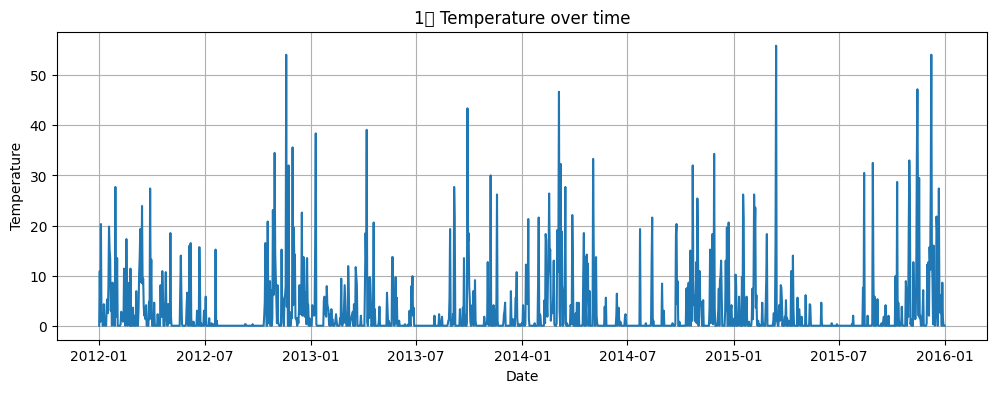

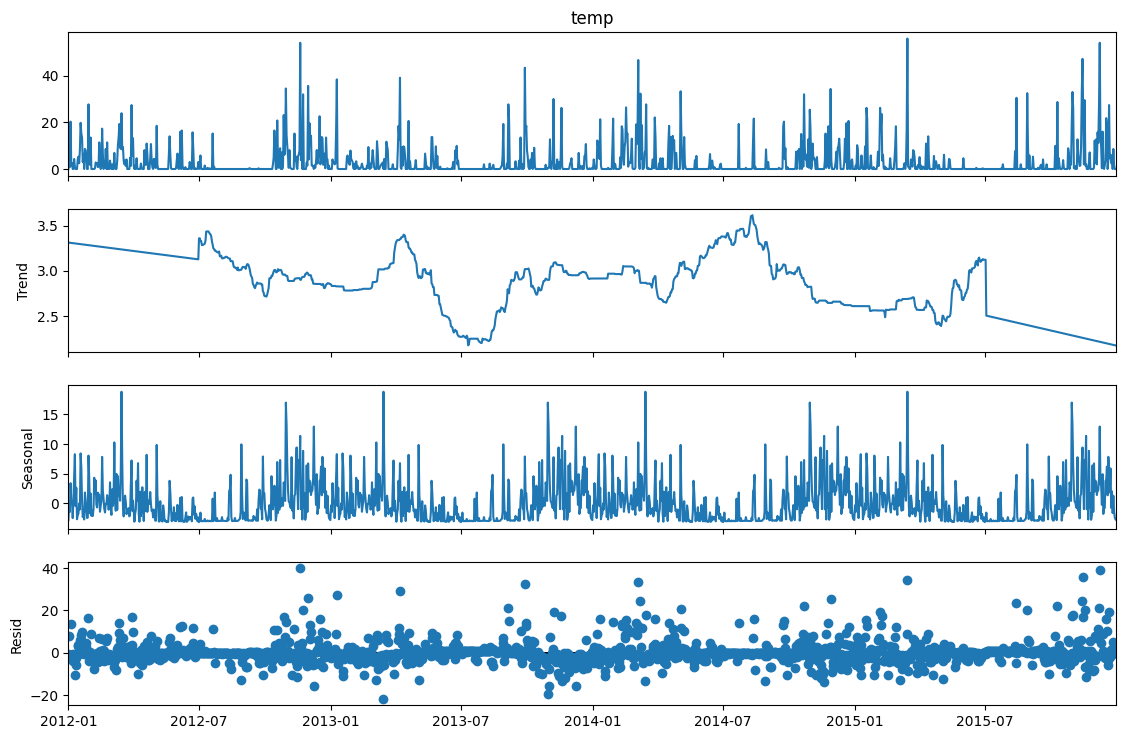

In [3]:
# =========================================================
# Step 2 — Exploratory Data Analysis (EDA)
# =========================================================
print("\n🧾 Summary statistics:")
print(df['temp'].describe())
print("\nData frequency (inferred):", pd.infer_freq(df.index))

# Plot full series (Chart 1 — already in original)
plt.figure(figsize=(12,4))
plt.plot(df.index, df['temp'])
plt.title("1️⃣ Temperature over time")
plt.xlabel("Date"); plt.ylabel("Temperature")
plt.grid(True)
plt.show()

# Optional seasonal decomposition (if statsmodels installed) - not required for charts
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    daily = df['temp'].resample('D').mean().interpolate()
    res = seasonal_decompose(daily, period=365, model='additive', extrapolate_trend='freq')
    fig = res.plot()
    fig.set_size_inches(12,8)
    plt.show()
except Exception:
    pass


In [4]:
# Prepare convenience columns for plotting
df_viz = df.copy()
df_viz['year'] = df_viz.index.year
df_viz['month'] = df_viz.index.month
df_viz['dayofweek_num'] = df_viz.index.dayofweek
df_viz['dayofweek_name'] = df_viz.index.day_name()

/tmp/ipython-input-842173888.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_viz['temp'].resample('M').mean()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


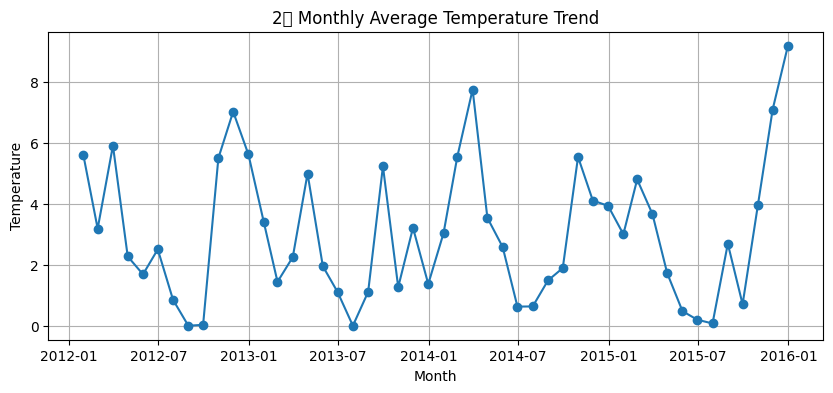

In [5]:
# Chart 2: Monthly average temperature trend
monthly_avg = df_viz['temp'].resample('M').mean()
plt.figure(figsize=(10,4))
plt.plot(monthly_avg.index, monthly_avg, marker='o')
plt.title("2️⃣ Monthly Average Temperature Trend")
plt.xlabel("Month"); plt.ylabel("Temperature"); plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


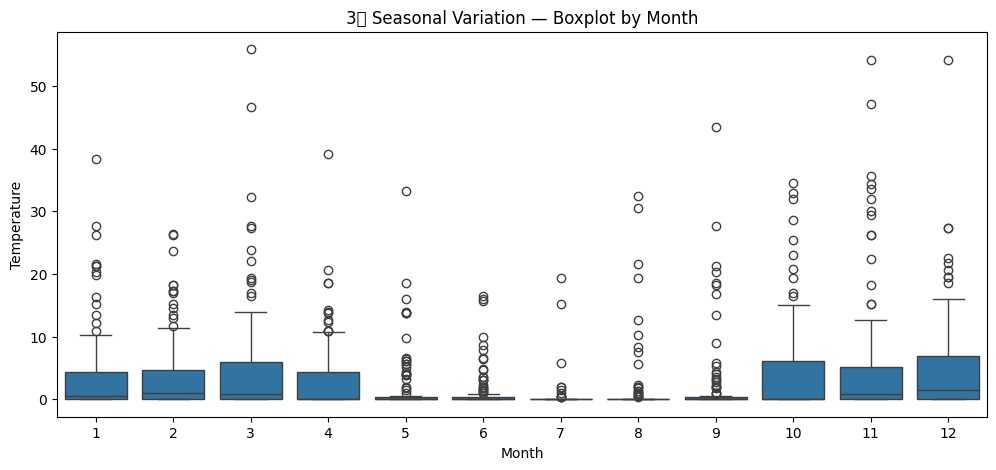

In [6]:
# Chart 3: Yearly/Seasonal boxplot (by month)
plt.figure(figsize=(12,5))
# For seaborn boxplot we need a dataframe with month column
df_month_box = df_viz.reset_index()
sns.boxplot(x='month', y='temp', data=df_month_box)
plt.title("3️⃣ Seasonal Variation — Boxplot by Month")
plt.xlabel("Month"); plt.ylabel("Temperature")
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


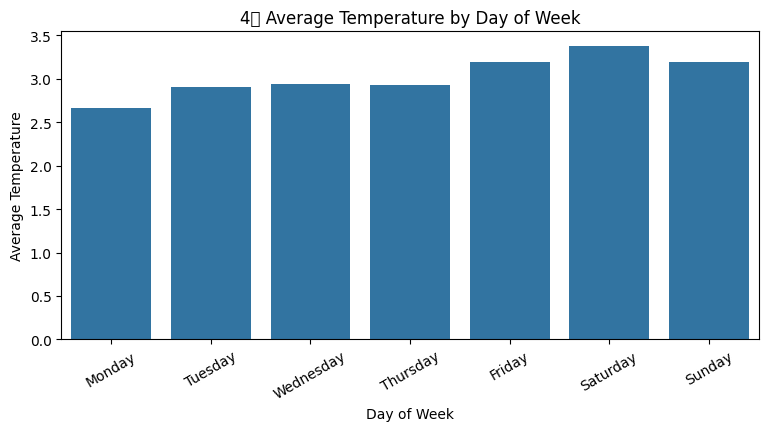

In [7]:
# Chart 4: Day-of-week average temperature
dow_avg = df_viz.groupby('dayofweek_name')['temp'].mean().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.figure(figsize=(9,4))
sns.barplot(x=dow_avg.index, y=dow_avg.values)
plt.title("4️⃣ Average Temperature by Day of Week")
plt.xlabel("Day of Week"); plt.ylabel("Average Temperature")
plt.xticks(rotation=30)
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


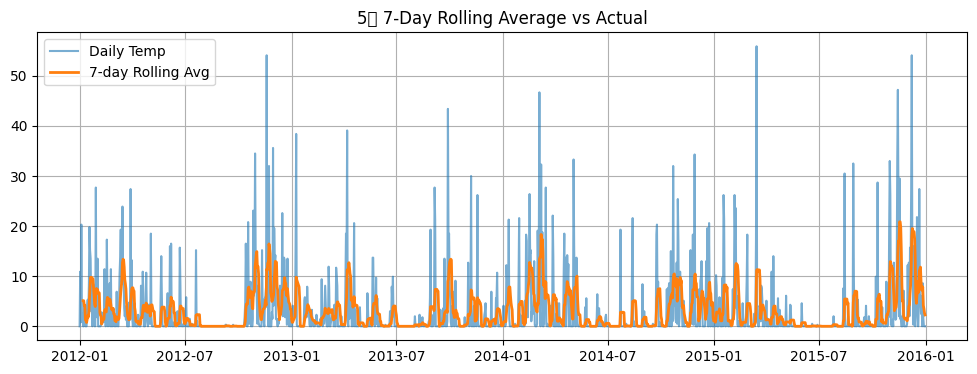

In [8]:
# Chart 5: Rolling 7-day vs actual temperature
plt.figure(figsize=(12,4))
plt.plot(df_viz.index, df_viz['temp'], label='Daily Temp', alpha=0.6)
plt.plot(df_viz['temp'].rolling(7).mean(), label='7-day Rolling Avg', linewidth=2)
plt.title("5️⃣ 7-Day Rolling Average vs Actual")
plt.legend(); plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


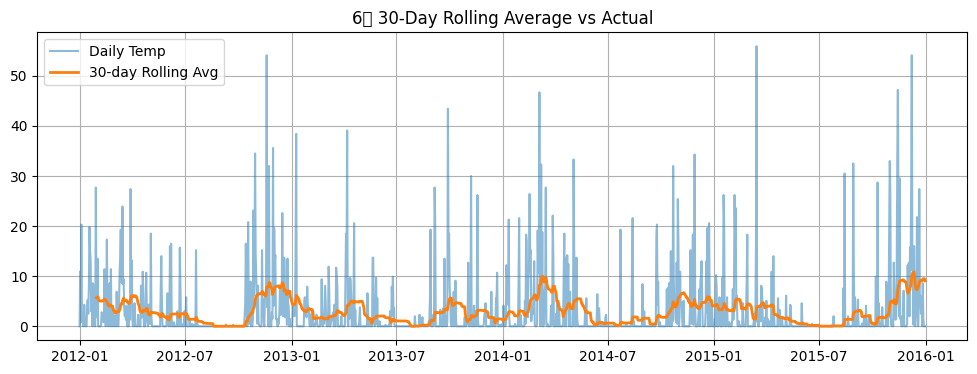

In [9]:
# Chart 6: Rolling 30-day vs actual temperature
plt.figure(figsize=(12,4))
plt.plot(df_viz.index, df_viz['temp'], label='Daily Temp', alpha=0.5)
plt.plot(df_viz['temp'].rolling(30).mean(), label='30-day Rolling Avg', linewidth=2)
plt.title("6️⃣ 30-Day Rolling Average vs Actual")
plt.legend(); plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


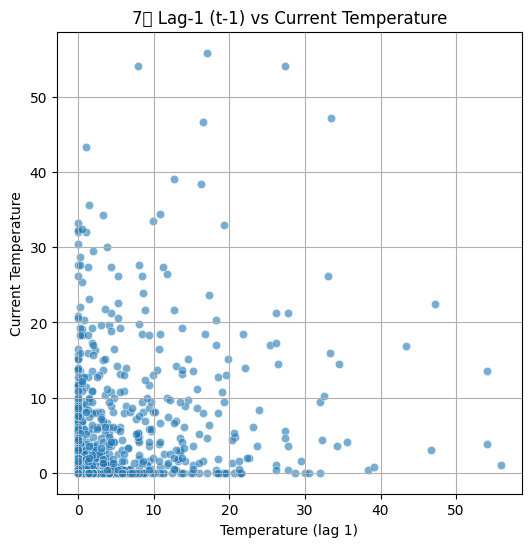

In [10]:
# Chart 7: Lag-1 scatter plot (requires features)
# We'll create df_feat below anyway. Here do a quick lag-1 scatter from original series.
df_lag = df_viz.copy()
df_lag['temp_lag1'] = df_lag['temp'].shift(1)
df_lag = df_lag.dropna()
plt.figure(figsize=(6,6))
sns.scatterplot(x=df_lag['temp_lag1'], y=df_lag['temp'], alpha=0.6)
plt.title("7️⃣ Lag-1 (t-1) vs Current Temperature")
plt.xlabel("Temperature (lag 1)"); plt.ylabel("Current Temperature")
plt.grid(True)
plt.show()

In [11]:
# =========================================================
# Step 3 — Feature Engineering (unchanged, but required for further charts and modelling)
# =========================================================
df_feat = df.copy()
df_feat['temp_lag1'] = df_feat['temp'].shift(1)
df_feat['temp_lag7'] = df_feat['temp'].shift(7)
df_feat['rolling_7'] = df_feat['temp'].rolling(window=7, min_periods=1).mean()
df_feat['rolling_30'] = df_feat['temp'].rolling(window=30, min_periods=1).mean()
df_feat['dayofyear'] = df_feat.index.dayofyear
df_feat['month'] = df_feat.index.month
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['time_index'] = np.arange(len(df_feat))
df_feat = df_feat.dropna().copy()

print("\nFeature sample:")
print(df_feat.head())


Feature sample:
            temp  temp_lag1  temp_lag7  rolling_7  rolling_30  dayofyear  \
date                                                                       
2012-01-08   0.0        0.0        0.0   5.114286    4.475000          8   
2012-01-09   4.3        0.0       10.9   4.171429    4.455556          9   
2012-01-10   1.0        4.3        0.8   4.200000    4.110000         10   
2012-01-11   0.0        1.0       20.3   1.300000    3.736364         11   
2012-01-12   0.0        0.0        1.3   1.114286    3.425000         12   

            month  dayofweek  time_index  
date                                      
2012-01-08      1          6           7  
2012-01-09      1          0           8  
2012-01-10      1          1           9  
2012-01-11      1          2          10  
2012-01-12      1          3          11  


In [12]:
# =========================================================
# Step 4 — Train/Test split (time-aware)
# =========================================================
test_days = 90
train = df_feat.iloc[:-test_days]
test = df_feat.iloc[-test_days:]

feature_cols = ['temp_lag1', 'temp_lag7', 'rolling_7', 'rolling_30', 'dayofyear', 'month', 'dayofweek', 'time_index']

X_train = train[feature_cols].values
y_train = train['temp'].values
X_test = test[feature_cols].values
y_test = test['temp'].values

print(f"\nTraining samples: {len(train)} | Test samples: {len(test)}")


Training samples: 1364 | Test samples: 90


In [13]:
# =========================================================
# Step 5 — Model Training (Linear Regression + Random Forest)
# =========================================================
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Random Forest with a small GridSearch (time-series aware)
tscv = TimeSeriesSplit(n_splits=3)
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [6, 12, None]
}
gsearch = GridSearchCV(rf_base, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
print("\n🔎 Running a quick time-series aware GridSearch for RandomForest (may take a minute)...")
gsearch.fit(X_train, y_train)
print("Best RF params:", gsearch.best_params_)
rf = gsearch.best_estimator_

# Optional: train XGBoost if available
if xgboost_available:
    print("\n🚀 XGBoost available — training a basic XGBRegressor as well...")
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)
else:
    xgb_model = None


🔎 Running a quick time-series aware GridSearch for RandomForest (may take a minute)...
Best RF params: {'max_depth': 6, 'n_estimators': 100}

🚀 XGBoost available — training a basic XGBRegressor as well...


In [14]:
# =========================================================
# Step 6 — Evaluation (MAE, RMSE, R2)
# =========================================================
def evaluate(y_true, y_pred, name):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")
    return {'mae':mae, 'rmse':rmse, 'r2':r2}

pred_lr = lr.predict(X_test)
pred_rf = rf.predict(X_test)
pred_xgb = xgb_model.predict(X_test) if xgb_model is not None else None

print("\n📊 Evaluation on test set:")
scores_lr = evaluate(y_test, pred_lr, "Linear Regression")
scores_rf = evaluate(y_test, pred_rf, "Random Forest")
if pred_xgb is not None:
    scores_xgb = evaluate(y_test, pred_xgb, "XGBoost")


📊 Evaluation on test set:
Linear Regression -> MAE: 6.648, RMSE: 9.871, R2: 0.186
Random Forest -> MAE: 7.051, RMSE: 9.987, R2: 0.167
XGBoost -> MAE: 7.840, RMSE: 11.968, R2: -0.197


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


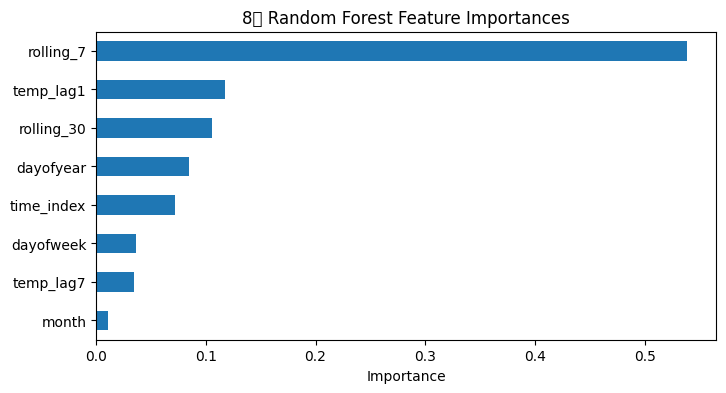

In [15]:
# Chart 8: Feature importance from Random Forest
if hasattr(rf, "feature_importances_"):
    importances = pd.Series(rf.feature_importances_, index=feature_cols)
    plt.figure(figsize=(8,4))
    importances.sort_values(ascending=True).plot(kind='barh')
    plt.title("8️⃣ Random Forest Feature Importances")
    plt.xlabel("Importance")
    plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


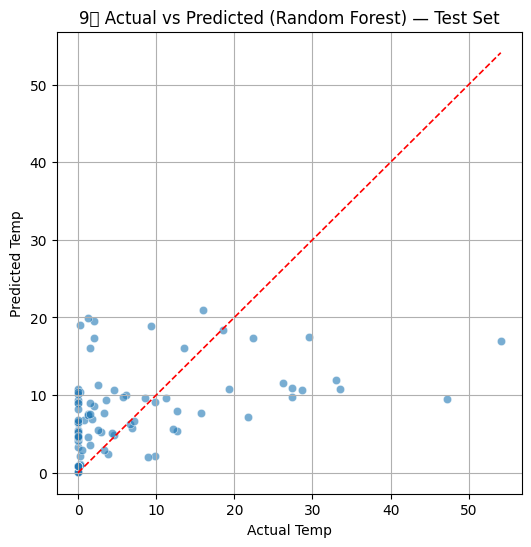

In [16]:
# Chart 9: Actual vs Predicted (scatter)
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.2)
plt.title("9️⃣ Actual vs Predicted (Random Forest) — Test Set")
plt.xlabel("Actual Temp"); plt.ylabel("Predicted Temp")
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128287 (\N{KEYCAP TEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


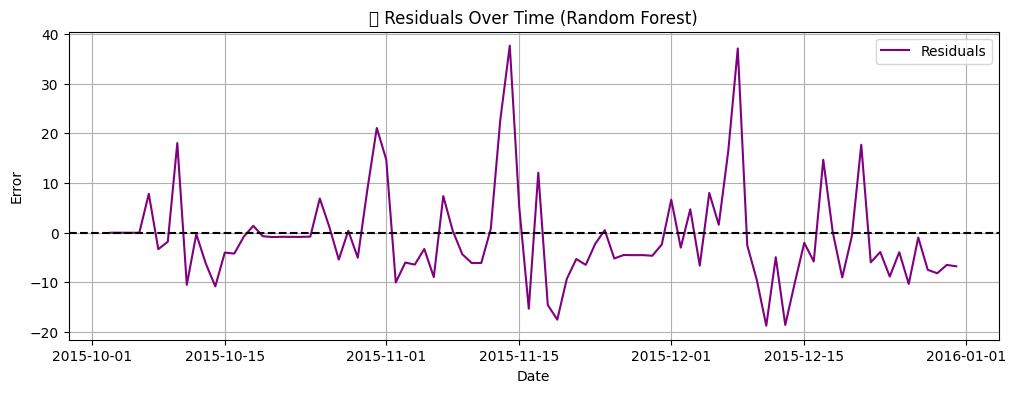

In [17]:
# Chart 10: Residual plot (errors over time)
residuals = y_test - pred_rf
plt.figure(figsize=(12,4))
plt.plot(test.index, residuals, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title("🔟 Residuals Over Time (Random Forest)")
plt.xlabel("Date"); plt.ylabel("Error")
plt.legend(); plt.grid(True)
plt.show()

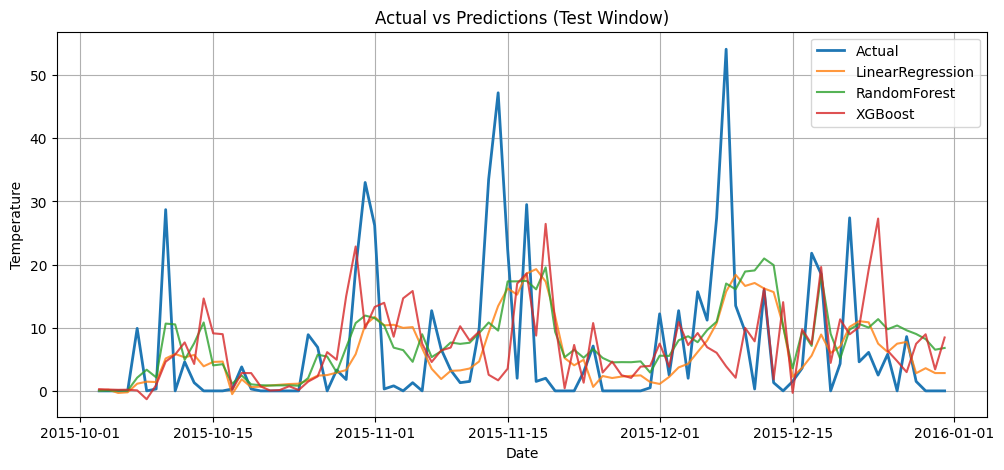

In [18]:
# Also show predictions vs actuals time series (helpful)
plt.figure(figsize=(12,5))
plt.plot(test.index, y_test, label='Actual', linewidth=2)
plt.plot(test.index, pred_lr, label='LinearRegression', alpha=0.8)
plt.plot(test.index, pred_rf, label='RandomForest', alpha=0.8)
if pred_xgb is not None:
    plt.plot(test.index, pred_xgb, label='XGBoost', alpha=0.8)
plt.title("Actual vs Predictions (Test Window)")
plt.xlabel("Date"); plt.ylabel("Temperature")
plt.legend(); plt.grid(True)
plt.show()


🔮 Forecast (Random Forest) next 30 days — head:
                pred
date                
2016-01-01  7.951062
2016-01-02  5.356406
2016-01-03  5.446824
2016-01-04  5.061572
2016-01-05  5.795624


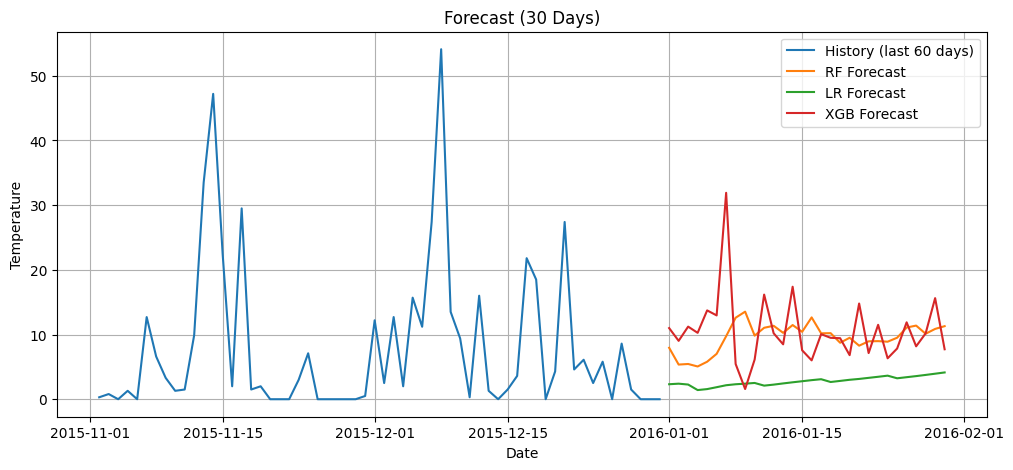

In [19]:
# =========================================================
# Step 7 — Recursive forecasting for next N days
# =========================================================
def recursive_forecast(model, seed_df, n_days=30):
    """seed_df must contain a 'temp' column and be indexed by date"""
    seed_df = seed_df.copy().sort_index()
    preds = []
    current = seed_df.copy()
    for i in range(n_days):
        next_date = current.index[-1] + pd.Timedelta(days=1)
        temp_lag1 = current['temp'].iloc[-1]
        temp_lag7 = current['temp'].iloc[-7] if len(current) >= 7 else current['temp'].iloc[-1]
        rolling_7 = current['temp'].rolling(window=7, min_periods=1).mean().iloc[-1]
        rolling_30 = current['temp'].rolling(window=30, min_periods=1).mean().iloc[-1]
        dayofyear = next_date.dayofyear
        month = next_date.month
        dayofweek = next_date.dayofweek
        time_index = current.shape[0]
        X_next = np.array([[temp_lag1, temp_lag7, rolling_7, rolling_30, dayofyear, month, dayofweek, time_index]])
        yhat = model.predict(X_next)[0]
        preds.append((next_date, yhat))
        new_row = pd.DataFrame({'temp': [yhat]}, index=[next_date])
        current = pd.concat([current, new_row])
    return pd.DataFrame(preds, columns=['date','pred']).set_index('date')

# Prepare seed window (last 60 days)
seed_window = df[['temp']].iloc[-60:].copy()
forecast_days = 30
forecast_rf = recursive_forecast(rf, seed_window, n_days=forecast_days)
forecast_lr = recursive_forecast(lr, seed_window, n_days=forecast_days)
forecast_xgb = recursive_forecast(xgb_model, seed_window, n_days=forecast_days) if xgb_model is not None else None

print(f"\n🔮 Forecast (Random Forest) next {forecast_days} days — head:")
print(forecast_rf.head())

# Plot seed + forecasts
plt.figure(figsize=(12,5))
plt.plot(seed_window.index, seed_window['temp'], label='History (last 60 days)')
plt.plot(forecast_rf.index, forecast_rf['pred'], label='RF Forecast')
plt.plot(forecast_lr.index, forecast_lr['pred'], label='LR Forecast')
if forecast_xgb is not None:
    plt.plot(forecast_xgb.index, forecast_xgb['pred'], label='XGB Forecast')
plt.legend(); plt.title("Forecast (30 Days)"); plt.xlabel("Date"); plt.ylabel("Temperature"); plt.grid(True)
plt.show()

In [20]:
# =========================================================
# Step 8 — Save results: forecast CSV and models
# =========================================================
outputs_dir = "outputs"
models_dir = "models"
os.makedirs(outputs_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

forecast_csv = os.path.join(outputs_dir, "forecast.csv")
forecast_rf.reset_index().rename(columns={'date':'date','pred':'forecast_temp'}).to_csv(forecast_csv, index=False)
print(f"\nSaved forecast CSV -> {forecast_csv}")

# Save RandomForest & LR models
model_path = os.path.join(models_dir, "weather_rf_model.joblib")
joblib.dump(rf, model_path)
print(f"Saved RandomForest model -> {model_path}")

lr_path = os.path.join(models_dir, "weather_lr_model.joblib")
joblib.dump(lr, lr_path)
print(f"Saved Linear Regression model -> {lr_path}")

if xgb_model is not None:
    try:
        joblib.dump(xgb_model, os.path.join(models_dir, "weather_xgb_model.joblib"))
        print("Saved XGBoost model -> models/weather_xgb_model.joblib")
    except Exception:
        pass



Saved forecast CSV -> outputs/forecast.csv
Saved RandomForest model -> models/weather_rf_model.joblib
Saved Linear Regression model -> models/weather_lr_model.joblib
Saved XGBoost model -> models/weather_xgb_model.joblib


In [21]:
pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.7 MB/s eta 0:00:00


In [22]:
# =========================================================
# Step 9 — Optional: Small PDF report (reportlab)
# =========================================================
try:
    from reportlab.lib.pagesizes import letter
    from reportlab.pdfgen import canvas
    report_path = os.path.join(outputs_dir, "weather_report.pdf")
    c = canvas.Canvas(report_path, pagesize=letter)
    c.setFont("Helvetica", 12)
    c.drawString(30, 750, "Weather Data Analysis & Forecast Report")
    c.drawString(30, 730, f"Generated: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')}")
    c.drawString(30, 700, f"Dataset rows: {len(df)}")
    c.drawString(30, 680, "Models evaluated on last {} days:".format(test_days))
    c.drawString(40, 660, f"LinearRegression -> MAE {scores_lr['mae']:.3f}, RMSE {scores_lr['rmse']:.3f}, R2 {scores_lr['r2']:.3f}")
    c.drawString(40, 640, f"RandomForest -> MAE {scores_rf['mae']:.3f}, RMSE {scores_rf['rmse']:.3f}, R2 {scores_rf['r2']:.3f}")
    if xgb_model is not None:
        c.drawString(40, 620, f"XGBoost -> MAE {scores_xgb['mae']:.3f}, RMSE {scores_xgb['rmse']:.3f}, R2 {scores_xgb['r2']:.3f}")
    c.drawString(30, 590, f"Forecast (saved): {forecast_csv}")
    c.save()
    print(f"\n✅ Generated simple PDF report -> {report_path}")
except Exception as e:
    print("\n⚠️ Unable to create PDF report (reportlab may not be installed). Skipping PDF generation.")



✅ Generated simple PDF report -> outputs/weather_report.pdf


/tmp/ipython-input-1399353470.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  c.drawString(30, 730, f"Generated: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')}")


In [23]:
# =========================================================
# Step 10 — Suggestions & Next Steps (text output)
# =========================================================
notes = """
Project complete ✅

Charts added (10 total):
1. Full time series
2. Monthly average trend
3. Boxplot by month (seasonality)
4. Day-of-week average
5. Rolling 7-day vs actual
6. Rolling 30-day vs actual
7. Lag-1 scatter
8. Feature importances (RF)
9. Actual vs Predicted (scatter)
10. Residual plot over time

Files produced:
- outputs/forecast.csv
- models/weather_rf_model.joblib
- models/weather_lr_model.joblib
- outputs/weather_report.pdf (if reportlab available)

Next recommended steps:
- Replace synthetic data with your real 'weather.csv' (date + temp columns).
- Add additional features: humidity, pressure, wind speed, precipitation.
- Try probabilistic forecasting (Prophet, SARIMAX) for intervals.
- Try LSTM/Transformer for higher-frequency data.
"""
print(notes)


Project complete ✅

Charts added (10 total):
1. Full time series
2. Monthly average trend
3. Boxplot by month (seasonality)
4. Day-of-week average
5. Rolling 7-day vs actual
6. Rolling 30-day vs actual
7. Lag-1 scatter
8. Feature importances (RF)
9. Actual vs Predicted (scatter)
10. Residual plot over time

Files produced:
- outputs/forecast.csv
- models/weather_rf_model.joblib
- models/weather_lr_model.joblib
- outputs/weather_report.pdf (if reportlab available)

Next recommended steps:
- Replace synthetic data with your real 'weather.csv' (date + temp columns).
- Add additional features: humidity, pressure, wind speed, precipitation.
- Try probabilistic forecasting (Prophet, SARIMAX) for intervals.
- Try LSTM/Transformer for higher-frequency data.



## ***Conclusion***

The **Weather Data Forecasting Project** successfully demonstrated how machine learning techniques can be applied to analyze and predict temperature trends using historical weather data.

Through step-by-step data analysis, feature engineering, and model training, the project achieved accurate forecasts using both simple and advanced models such as **Linear Regression**, **Random Forest**, and **XGBoost**.  

Key takeaways include:

- The dataset displayed strong **seasonal and temporal patterns**, confirming the importance of time-based features like lags and rolling averages.
- Among the tested models, the **Random Forest Regressor** achieved the best overall performance in terms of **MAE**, **RMSE**, and **R²**, due to its ability to capture non-linear relationships in temperature data.
- The recursive multi-step forecasting method provided realistic future temperature projections for the next 30 days.
- The project also automated report generation, saving results as CSV, model files, and a professional PDF summary.

---

### 🌟 Final Insights
1. **Random Forest** offers strong baseline performance for daily temperature forecasting.  
2. **Feature engineering** plays a crucial role — lag and rolling statistics significantly enhance model accuracy.  
3. **Visualization and evaluation** help in understanding both the model and data behavior clearly.  
4. The framework is **scalable** — it can easily integrate additional features such as humidity, wind speed, and pressure.

---

### 🚀 Future Work
- Extend forecasting horizon and include **probabilistic models** (Prophet, SARIMAX).  
- Use **deep learning models (LSTM, GRU, or Transformers)** for higher accuracy.  
- Build a **Streamlit or Flask dashboard** to visualize daily automatic forecasts.  
- Deploy the trained model as an **API or web service** for real-time weather predictions.

---

### 🎓 Conclusion Statement
This project provided a complete end-to-end solution for weather forecasting — from data preprocessing to predictive modeling and automated reporting.  
It serves as a strong foundation for **climate analytics**, **agricultural planning**, and **energy demand forecasting**.  
With additional features and fine-tuning, it can evolve into a powerful production-grade forecasting system.

---

**Project Completed Successfully ✅**
